IMPORT ALL THE PACKAGES

In [1]:
!pip install wfdb numpy scipy matplotlib pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 51.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Signal Metadata Analysis**

In [3]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Load a record (change 'slp01a' to your specific file name without extension)
record = wfdb.rdrecord('slp60', pn_dir='slpdb')
annotation = wfdb.rdann('slp60', 'st', pn_dir='slpdb')

# Inspect metadata
print("Signal names:", record.sig_name)
print("Sampling frequency:", record.fs)
print("Number of samples:", record.sig_len)
print("Number of channels:", record.n_sig)

Signal names: ['ECG', 'BP', 'EEG (C3-O1)', 'Resp (abdominal)', 'Resp (nasal)', 'SV', 'SO2']
Sampling frequency: 250
Number of samples: 5325000
Number of channels: 7


**Channel Selection**

In [4]:
import pandas as pd
from scipy import signal
from scipy.fft import fft, fftfreq

# Extract EEG channel only
eeg_index = record.sig_name.index('EEG (C3-O1)')
eeg_signal = record.p_signal[:, eeg_index]
fs = record.fs  # Sampling frequency

# Print basic info
print("Sampling Frequency (Hz):", fs)
print("EEG Signal Length:", len(eeg_signal))
print("Duration (minutes):", len(eeg_signal)/(fs*60))

Sampling Frequency (Hz): 250
EEG Signal Length: 5325000
Duration (minutes): 355.0


**Signal Visualization**

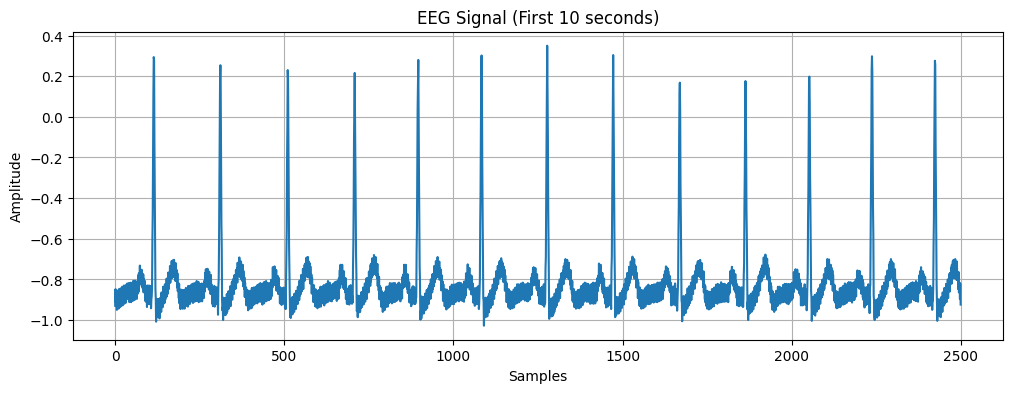

In [5]:
# Plot the first EEG channel for the first 10 seconds
seconds = 10
samples = int(seconds * record.fs)

plt.figure(figsize=(12, 4))
plt.plot(record.p_signal[:samples, 0])
plt.title(f'EEG Signal (First {seconds} seconds)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [6]:
# Check for NaNs or extreme values
print("Contains NaNs:", np.isnan(eeg_signal).any())
print("Min:", np.min(eeg_signal), "Max:", np.max(eeg_signal))

# Optional: Replace NaNs if any
eeg_signal = np.nan_to_num(eeg_signal)

Contains NaNs: False
Min: -0.13214683390541745 Max: 0.15073573393946643


**Signal Statistics**

In [8]:
stats = {
    "Mean": np.mean(eeg_signal),
    "Standard Deviation": np.std(eeg_signal),
    "Minimum": np.min(eeg_signal),
    "Maximum": np.max(eeg_signal),
    "Median": np.median(eeg_signal)
}

print("EEG Signal Statistics:")
print(pd.Series(stats))

EEG Signal Statistics:
Mean                  0.009250
Standard Deviation    0.011273
Minimum              -0.132147
Maximum               0.150736
Median                0.009202
dtype: float64


**Noise and Artifact Detection**

In [9]:
# Simple Z-score based noise detection
z_scores = (eeg_signal - np.mean(eeg_signal)) / np.std(eeg_signal)
threshold = 5  # Customize based on dataset
artifact_indices = np.where(np.abs(z_scores) > threshold)[0]
print(f"Detected {len(artifact_indices)} potential artifacts (Z > {threshold})")

Detected 32239 potential artifacts (Z > 5)


**Segment-wise Temporal Analysis**

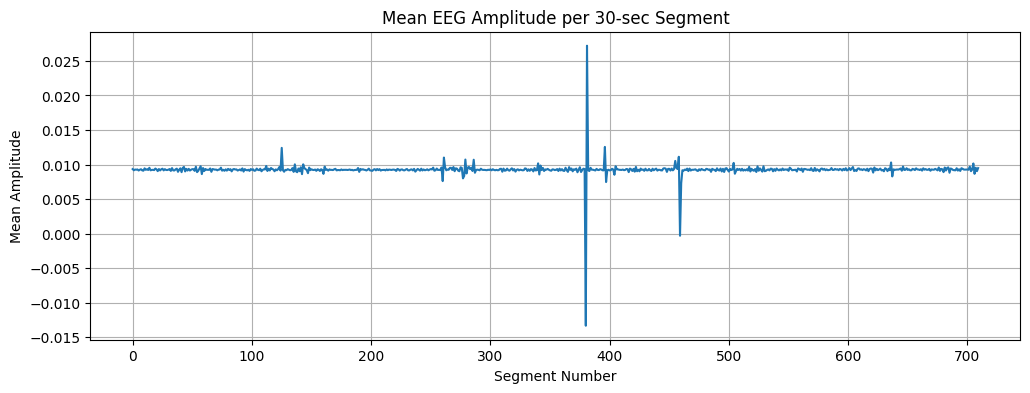

In [10]:
segment_duration = 30  # seconds
samples_per_segment = fs * segment_duration
num_segments = len(eeg_signal) // samples_per_segment

segment_means = []
for i in range(num_segments):
    segment = eeg_signal[i*samples_per_segment : (i+1)*samples_per_segment]
    segment_means.append(np.mean(segment))

plt.figure(figsize=(12, 4))
plt.plot(segment_means)
plt.title("Mean EEG Amplitude per 30-sec Segment")
plt.xlabel("Segment Number")
plt.ylabel("Mean Amplitude")
plt.grid(True)
plt.show()

**Frequency-Domain Analysis**

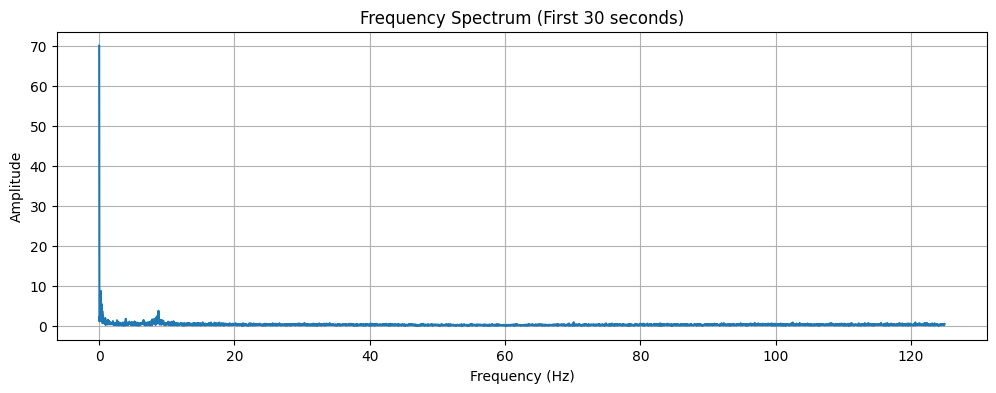

In [11]:
# Take 30 seconds of EEG for FFT
segment = eeg_signal[:fs*30]
N = len(segment)
yf = fft(segment)
xf = fftfreq(N, 1/fs)

plt.figure(figsize=(12, 4))
plt.plot(xf[:N//2], np.abs(yf[:N//2]))
plt.title("Frequency Spectrum (First 30 seconds)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

**Frequency-Domain Analysis WITH BANDS**

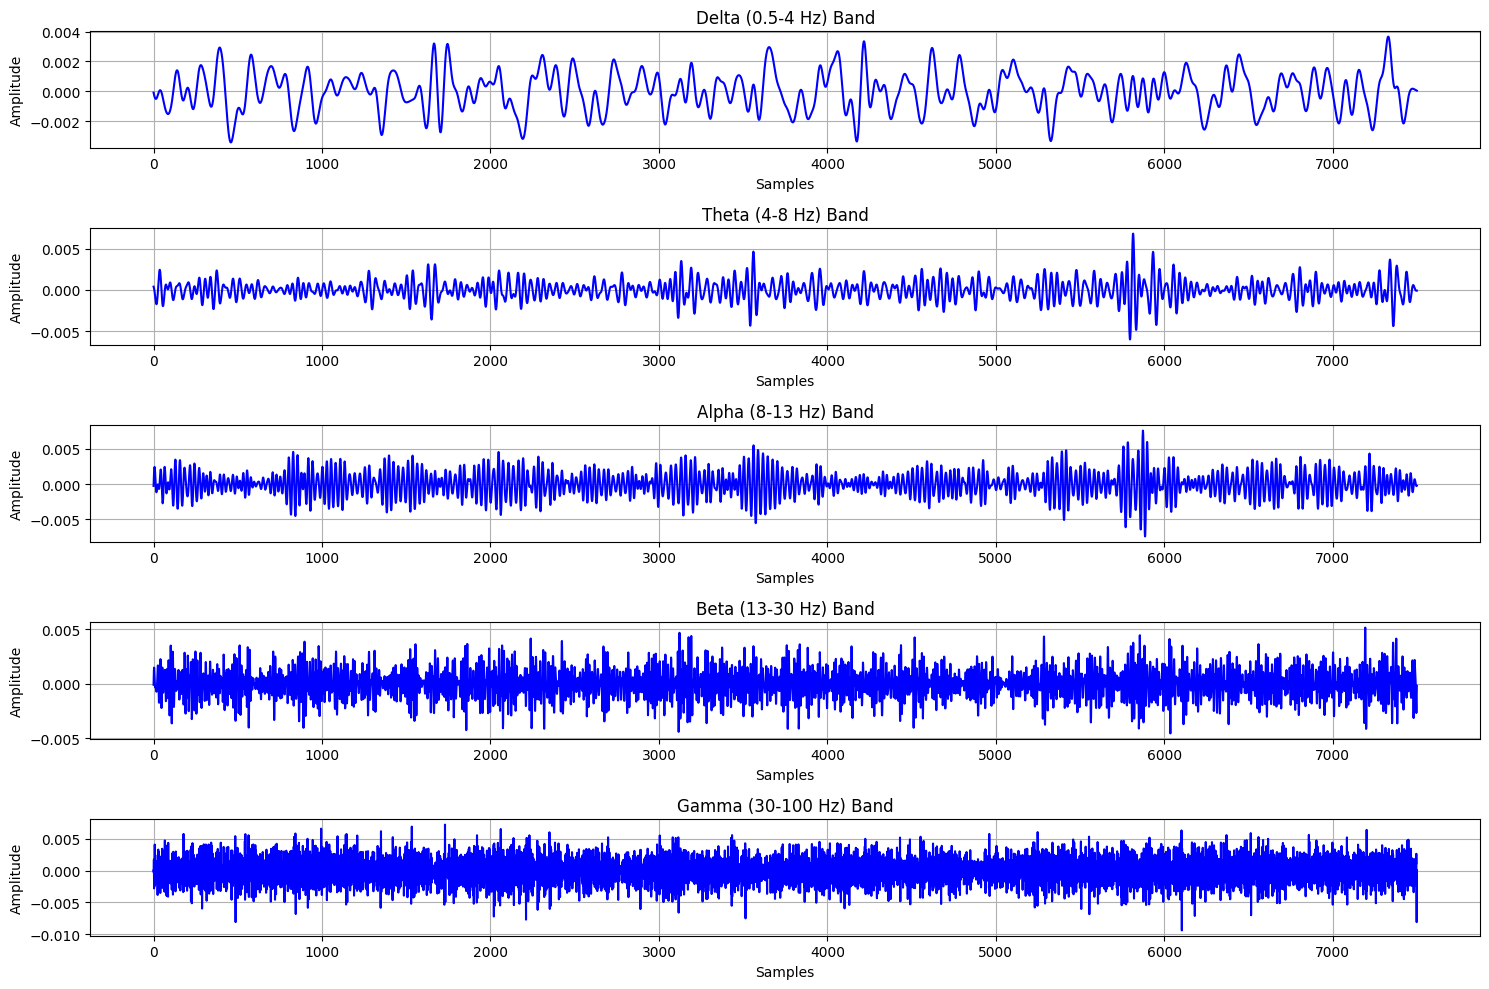

In [12]:
from scipy.signal import butter, filtfilt

# Helper function to apply bandpass filter
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Use a 30-second EEG segment
eeg_segment = eeg_signal[:fs * 30]

# Define brainwave bands
bands = {
    'Delta (0.5-4 Hz)': (0.5, 4),
    'Theta (4-8 Hz)': (4, 8),
    'Alpha (8-13 Hz)': (8, 13),
    'Beta (13-30 Hz)': (13, 30),
    'Gamma (30-100 Hz)': (30, 100)
}

# Plot filtered signals for each band
plt.figure(figsize=(15, 10))
for i, (band, (low, high)) in enumerate(bands.items()):
    filtered = bandpass_filter(eeg_segment, low, high, fs)
    plt.subplot(len(bands), 1, i + 1)
    plt.plot(filtered, color='b')
    plt.title(f'{band} Band')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid(True)

plt.tight_layout()
plt.show()

**Micro-Arousal Detection **

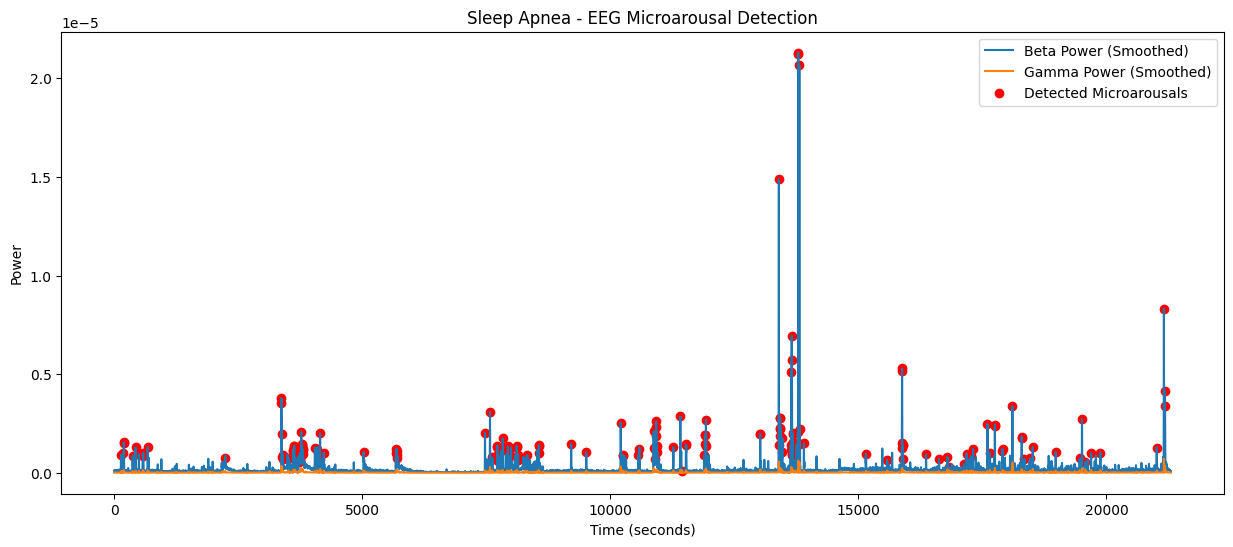

Total apnea-related microarousals detected: 174


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram, find_peaks

# Bandpass filter (0.5–40 Hz)
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=250, order=4):
    nyquist = 0.5 * fs
    b, a = butter(order, [lowcut / nyquist, highcut / nyquist], btype='band')
    return filtfilt(b, a, signal)

# Apply filter
filtered_eeg = bandpass_filter(eeg_signal, fs=fs)

# Calculate spectrogram
f, t, Sxx = spectrogram(filtered_eeg, fs=fs, nperseg=fs*2, noverlap=fs)

# Focus on beta and gamma bands
beta_band = (f >= 13) & (f <= 30)
gamma_band = (f > 30) & (f <= 100)

# Power over time
beta_power = np.mean(Sxx[beta_band, :], axis=0)
gamma_power = np.mean(Sxx[gamma_band, :], axis=0)

# Smooth power signals
beta_power_smooth = np.convolve(beta_power, np.ones(5)/5, mode='same')
gamma_power_smooth = np.convolve(gamma_power, np.ones(5)/5, mode='same')

# Detect peaks (microarousals)
beta_peaks, _ = find_peaks(beta_power_smooth, height=np.mean(beta_power_smooth) + 2*np.std(beta_power_smooth))
gamma_peaks, _ = find_peaks(gamma_power_smooth, height=np.mean(gamma_power_smooth) + 2*np.std(gamma_power_smooth))

# Combine detections
all_peaks = np.union1d(beta_peaks, gamma_peaks)

# Plot
plt.figure(figsize=(15,6))
plt.plot(t, beta_power_smooth, label='Beta Power (Smoothed)')
plt.plot(t, gamma_power_smooth, label='Gamma Power (Smoothed)')
plt.scatter(t[all_peaks], beta_power_smooth[all_peaks], color='red', label='Detected Microarousals')
plt.xlabel('Time (seconds)')
plt.ylabel('Power')
plt.legend()
plt.title('Sleep Apnea - EEG Microarousal Detection')
plt.show()

print(f"Total apnea-related microarousals detected: {len(all_peaks)}")

**Annotation Analysis and Label Distribution**

In [14]:
# Load annotations
ann = wfdb.rdann('slp16', 'st', pn_dir='slpdb')
print("Annotation Types:", set(ann.aux_note))

# Create DataFrame of annotations
ann_df = pd.DataFrame({
    'Sample': ann.sample,
    'Time (sec)': ann.sample / fs,
    'Stage': ann.aux_note
})

print(ann_df.head())

Annotation Types: {'1 CA', '2 H', 'R', '1', '1 H', 'W X', 'W CAA', '2 X L', '2 CA', 'W X X', '1 HA CA', 'W', 'W X CAA', 'R X', '2 CAA', 'W HA', 'R L', 'R HA', 'W HA X', '1 HA HA', '1 HA', '1 HA X', '1 CAA X', '1 CAA', '4', '1 X X', '2 HA', '3', '2 X X', 'W CAA HA', 'R LLLL LLL', '1 X', '2', 'W HA HA', '2 X', '1 CAA HA'}
   Sample  Time (sec) Stage
0  195000       780.0     W
1  202500       810.0     W
2  210000       840.0     W
3  217500       870.0     W
4  225000       900.0     W


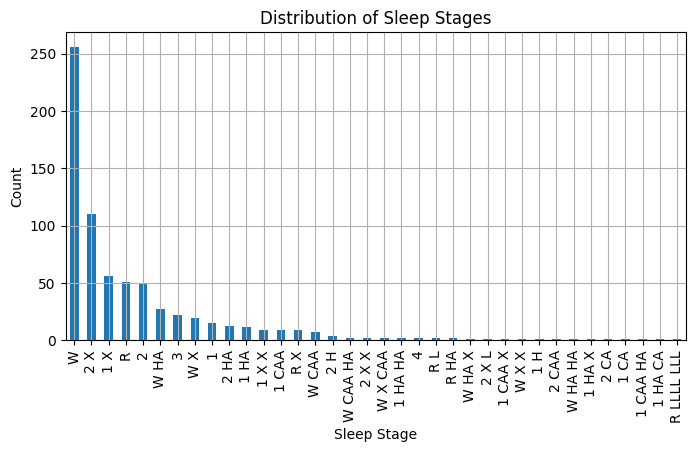

In [15]:
# Clean up stage labels
cleaned_labels = [s.strip() if s else "None" for s in ann.aux_note]
label_series = pd.Series(cleaned_labels)
label_counts = label_series.value_counts()

# Plot
plt.figure(figsize=(8, 4))
label_counts.plot(kind='bar')
plt.title("Distribution of Sleep Stages")
plt.xlabel("Sleep Stage")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# **DATA PREPROCESS STEPS**

**Feature extraction**

In [22]:
!pip install antropy

import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from antropy import spectral_entropy
import wfdb


fs = record.fs

eeg_index = record.sig_name.index('EEG (C3-O1)')
eeg_signal = record.p_signal[:, eeg_index]
eeg_signal = np.nan_to_num(eeg_signal)  # remove NaNs


# -------------------------------------------
# Create Labels for 30-second Segments
# -------------------------------------------
segment_length = fs * 30
n_segments = len(eeg_signal) // segment_length

apnea_keywords = ['H', 'HA', 'CA', 'CAA']  # hypopnea, apnea, central apnea etc.

# Updated label assignment logic
y = np.zeros(n_segments)

for sample, label in zip(annotation.sample, annotation.aux_note):
    if any(keyword in label for keyword in apnea_keywords):
        segment_index = sample // segment_length
        if segment_index < len(y):
            y[segment_index] = 1

# -------------------------------------------
# Feature Extraction per Segment
# -------------------------------------------
def extract_features(epoch, fs):
    freqs, psd = welch(epoch, fs)

    def bandpower(fmin, fmax):
        idx = np.logical_and(freqs >= fmin, freqs <= fmax)
        return np.sum(psd[idx])

    features = [
        np.mean(epoch),
        np.std(epoch),
        skew(epoch),
        kurtosis(epoch),
        np.sqrt(np.mean(epoch**2)),  # RMS
        bandpower(0.5, 4),   # Delta
        bandpower(4, 8),     # Theta
        bandpower(8, 13),    # Alpha
        bandpower(13, 30),   # Beta
        bandpower(30, 50),   # Gamma
        spectral_entropy(epoch, sf=fs, method='welch', normalize=True),
        freqs[np.argmax(psd)]  # Peak frequency
    ]
    return features

X = []
for i in range(n_segments):
    segment = eeg_signal[i * segment_length : (i + 1) * segment_length]
    X.append(extract_features(segment, fs))

X = np.array(X)

**normalise, train test split, dim reduction**

In [23]:

# -------------------------------------------
# Remove empty/incomplete segments
# -------------------------------------------
valid_indices = ~np.isnan(X).any(axis=1)
X = X[valid_indices]
y = y[valid_indices]

# -------------------------------------------
# Normalize Features
# -------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from collections import Counter
print("Label distribution (full dataset):", Counter(y))

# -------------------------------------------
# Train-Test Split (Stratified)
# -------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------------------------------
# Dimensionality Reduction for QML
# -------------------------------------------
selector = SelectKBest(score_func=f_classif, k=2)
X_qml = selector.fit_transform(X_scaled, y)

# -------------------------------------------
# Export for later use
# -------------------------------------------
df = pd.DataFrame(X_scaled)
df['label'] = y
df.to_csv('processed_sleep_apnea_features.csv', index=False)

print("Preprocessing complete.")
print("Feature matrix shape:", X.shape)
print("QML-compatible shape:", X_qml.shape)
print("Train samples:", len(X_train), "Test samples:", len(X_test))

Label distribution (full dataset): Counter({np.float64(0.0): 582, np.float64(1.0): 128})
Preprocessing complete.
Feature matrix shape: (710, 12)
QML-compatible shape: (710, 2)
Train samples: 568 Test samples: 142


# **CLASSICAL SVM**
with class weight balanced

Accuracy: 59.86 %
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.59      0.71       116
         1.0       0.25      0.62      0.36        26

    accuracy                           0.60       142
   macro avg       0.56      0.61      0.53       142
weighted avg       0.76      0.60      0.64       142



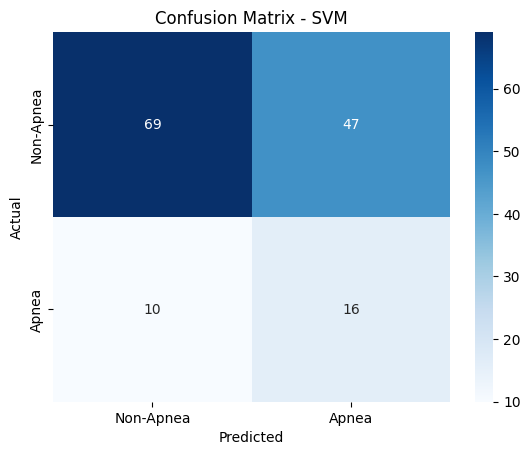

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train SVM
clf = SVC(kernel='rbf',  class_weight='balanced',random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Apnea', 'Apnea'], yticklabels=['Non-Apnea', 'Apnea'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()


**to improve svm metrics- use GridSearchCV**

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

         0.0       0.85      0.72      0.78       116
         1.0       0.26      0.42      0.32        26

    accuracy                           0.67       142
   macro avg       0.55      0.57      0.55       142
weighted avg       0.74      0.67      0.70       142



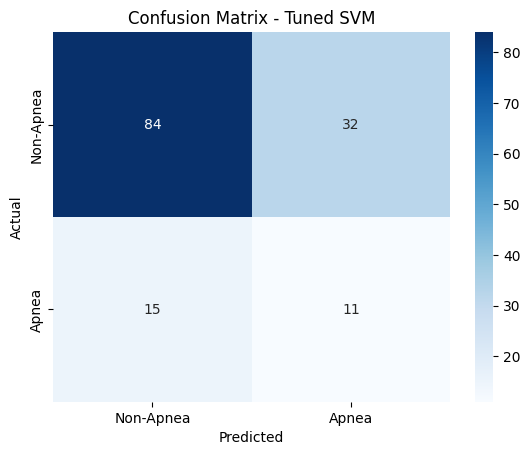

In [27]:
from sklearn.model_selection import GridSearchCV

# Define param grid
param_grid = {
    'C': [0.1, 1, 10, 50, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=1, scoring='f1_macro')
grid.fit(X_train, y_train)

# Best model
best_svm = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Predict
y_pred = best_svm.predict(X_test)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Apnea', 'Apnea'], yticklabels=['Non-Apnea', 'Apnea'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned SVM')
plt.show()


**plot roc and precision graphs for SVM**

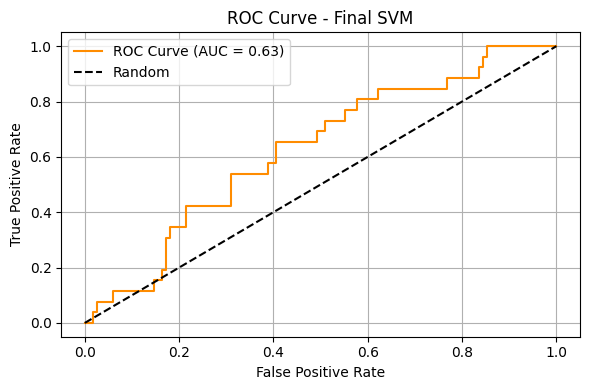

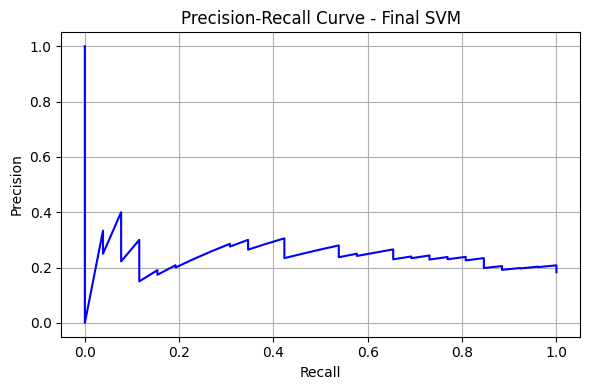

In [29]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve,
    RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

# Predict probabilities (needed for ROC)
y_score = best_svm.decision_function(X_test)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final SVM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label='Precision-Recall Curve', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Final SVM')
plt.grid(True)
plt.tight_layout()
plt.show()


**save the imort variables to reload after restart **

In [34]:
import pandas as pd

# Classical feature matrix and labels
pd.DataFrame(X_scaled).to_csv("X_scaled.csv", index=False)
pd.Series(y).to_csv("y.csv", index=False)

# Classical SVM splits
pd.DataFrame(X_train).to_csv("X_train.csv", index=False)
pd.DataFrame(X_test).to_csv("X_test.csv", index=False)
pd.Series(y_train).to_csv("y_train.csv", index=False)
pd.Series(y_test).to_csv("y_test.csv", index=False)

# QML features (2D)
pd.DataFrame(X_qml).to_csv("X_qml.csv", index=False)


to resolve the numpy version conflict between the qiskit and global , we install specific versions compatible with qiskit

In [ ]:
# Fix conflicting versions only in the current runtime
!pip uninstall -y pandas numpy
!pip install pandas==1.5.3 numpy==1.23.5

# Reinstall Qiskit Machine Learning
!pip install qiskit qiskit-machine-learning --upgrade



Found existing installation: pandas 1.5.3
Uninstalling pandas-1.5.3:
  Successfully uninstalled pandas-1.5.3
Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
  Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.0 MB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pennylane-qiskit 0.41.0.post0 requires qiskit<1.3,>=0.32, but you have qiskit 2.0.2 which is incompatible.
wfdb 4.3.0 requires numpy>=1.26.4, but you have numpy 1.23.5 which is incompatible.
wfdb 4.3.0 requir

ERROR: Operation cancelled by user
^C


Reload all the variables stored in dataframes earlier to avoid rereun of all the cells again

In [1]:
import pandas as pd
import numpy as np

# Load saved feature sets
X_scaled = pd.read_csv("X_scaled.csv").values
y = pd.read_csv("y.csv", header=None).values.flatten()

X_train = pd.read_csv("X_train.csv").values
X_test = pd.read_csv("X_test.csv").values
y_train = pd.read_csv("y_train.csv", header=None).values.flatten()
y_test = pd.read_csv("y_test.csv", header=None).values.flatten()

X_qml = pd.read_csv("X_qml.csv").values


# Clean slate install for Qiskit and Aer (matching versions)

In [4]:
# Clean slate install for Qiskit and Aer (matching versions)
!pip uninstall -y qiskit qiskit-aer
!pip install 'qiskit==0.43.1' 'qiskit-aer==0.12.0' qiskit-machine-learning


Found existing installation: qiskit 2.0.2
Uninstalling qiskit-2.0.2:
  Successfully uninstalled qiskit-2.0.2
Found existing installation: qiskit-aer 0.16.0
Uninstalling qiskit-aer-0.16.0:
  Successfully uninstalled qiskit-aer-0.16.0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of qiskit-machine-learning to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

reload again the dataframes

In [1]:
import pandas as pd
import numpy as np

# Load saved feature sets
X_scaled = pd.read_csv("X_scaled.csv").values
y = pd.read_csv("y.csv", header=None).values.flatten()

X_train = pd.read_csv("X_train.csv").values
X_test = pd.read_csv("X_test.csv").values
y_train = pd.read_csv("y_train.csv", header=None).values.flatten()
y_test = pd.read_csv("y_test.csv", header=None).values.flatten()

X_qml = pd.read_csv("X_qml.csv").values


**imports for QSVM**

In [2]:
# Basic setup (works with latest Qiskit)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC

# Set random seed for reproducibility
np.random.seed(42)


# **QSVM**

balance the data to avoid misclassify

In [9]:
# Fix label mismatch
if len(X_qml) != len(y):
    min_len = min(len(X_qml), len(y))
    X_qml = X_qml[:min_len]
    y = y[:min_len]
from sklearn.model_selection import train_test_split

from sklearn.utils import resample
import numpy as np

# Split first (again to get matching sets)
X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(
    X_qml, y, test_size=0.2, stratify=y, random_state=42
)

# Separate minority and majority classes
X_train_apnea = X_train_q[y_train_q == 1]
X_train_normal = X_train_q[y_train_q == 0]
y_train_apnea = y_train_q[y_train_q == 1]
y_train_normal = y_train_q[y_train_q == 0]

# Upsample minority (apnea) to match majority
X_apnea_upsampled, y_apnea_upsampled = resample(
    X_train_apnea, y_train_apnea,
    replace=True,
    n_samples=len(y_train_normal),
    random_state=42
)

# Combine balanced training data
X_train_balanced = np.vstack((X_train_normal, X_apnea_upsampled))
y_train_balanced = np.concatenate((y_train_normal, y_apnea_upsampled))

print("Balanced training data shape:", X_train_balanced.shape)


Balanced training data shape: (932, 2)


**use of Pauli for Feature Map ** on balanced data in qsvm (qsvm not supoort class weight balance)

In [10]:
from qiskit.circuit.library import PauliFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC

# Create simulator
simulator = AerSimulator(method='statevector')

# Use Pauli feature map (alternative to ZZ)
feature_map = PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'])

# Quantum kernel
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=simulator)


**qsvm **

In [11]:
qsvc = QSVC(quantum_kernel=quantum_kernel)
qsvc.fit(X_train_balanced, y_train_balanced)

# Predict on original test set
y_pred_qsvm = qsvc.predict(X_test_q)


ERROR:stevedore.extension:Could not load 'ibm_backend': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_backend': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': No module named 'qiskit.primitives.containers'


Improved QSVM Accuracy: 57.75 %
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.59      0.70       116
         1.0       0.22      0.50      0.30        26

    accuracy                           0.58       142
   macro avg       0.53      0.55      0.50       142
weighted avg       0.73      0.58      0.62       142



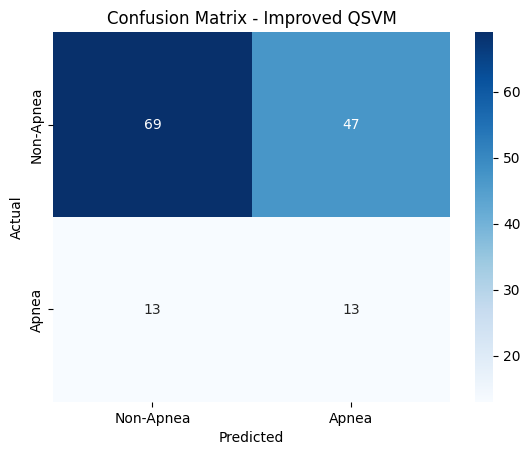

In [12]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy and report
print("Improved QSVM Accuracy:", round(accuracy_score(y_test_q, y_pred_qsvm) * 100, 2), "%")
print("Classification Report:\n", classification_report(y_test_q, y_pred_qsvm))

# Confusion Matrix
cm = confusion_matrix(y_test_q, y_pred_qsvm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Apnea', 'Apnea'], yticklabels=['Non-Apnea', 'Apnea'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Improved QSVM")
plt.show()


resample and balance the data for both svm and qsvm

In [13]:
from sklearn.utils import resample
import numpy as np

# Split the full data for both models
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_qml, y, test_size=0.2, stratify=y, random_state=42
)

# Separate the classes
X_apnea = X_train_bal[y_train_bal == 1]
X_normal = X_train_bal[y_train_bal == 0]
y_apnea = y_train_bal[y_train_bal == 1]
y_normal = y_train_bal[y_train_bal == 0]

# Upsample minority (apnea)
X_apnea_upsampled, y_apnea_upsampled = resample(
    X_apnea, y_apnea,
    replace=True,
    n_samples=len(y_normal),
    random_state=42
)

# Combine balanced training set
X_train_resampled = np.vstack((X_normal, X_apnea_upsampled))
y_train_resampled = np.concatenate((y_normal, y_apnea_upsampled))

print("✅ Resampled training data shape:", X_train_resampled.shape)


✅ Resampled training data shape: (932, 2)



**SVM with the resampled data**

🎯 Resampled SVM Accuracy: 59.15 %
Classification Report (SVM):
               precision    recall  f1-score   support

         0.0       0.89      0.57      0.69       116
         1.0       0.26      0.69      0.38        26

    accuracy                           0.59       142
   macro avg       0.58      0.63      0.54       142
weighted avg       0.78      0.59      0.64       142



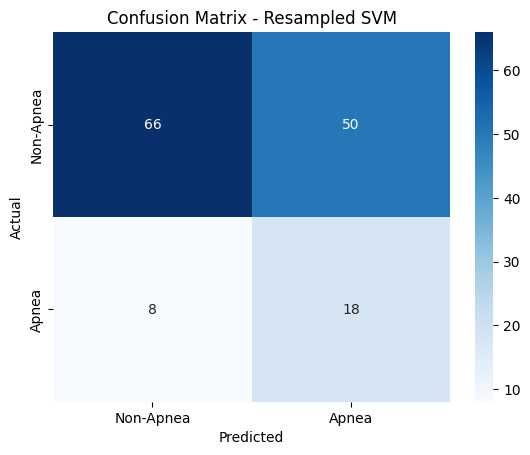

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classical SVM — no need for class_weight now
svm_model = SVC(kernel='rbf', C=1, gamma=1, random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm_model.predict(X_test_bal)

# Evaluation
print("🎯 Resampled SVM Accuracy:", round(accuracy_score(y_test_bal, y_pred_svm) * 100, 2), "%")
print("Classification Report (SVM):\n", classification_report(y_test_bal, y_pred_svm))

# Confusion matrix
cm = confusion_matrix(y_test_bal, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Apnea', 'Apnea'], yticklabels=['Non-Apnea', 'Apnea'])
plt.title("Confusion Matrix - Resampled SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**QSVM with resample balanced data- Pauli Feature Map**

ERROR:stevedore.extension:Could not load 'ibm_backend': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_backend': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': No module named 'qiskit.primitives.containers'


🎯 Resampled QSVM Accuracy: 57.75 %
Classification Report (QSVM):
               precision    recall  f1-score   support

         0.0       0.84      0.59      0.70       116
         1.0       0.22      0.50      0.30        26

    accuracy                           0.58       142
   macro avg       0.53      0.55      0.50       142
weighted avg       0.73      0.58      0.62       142



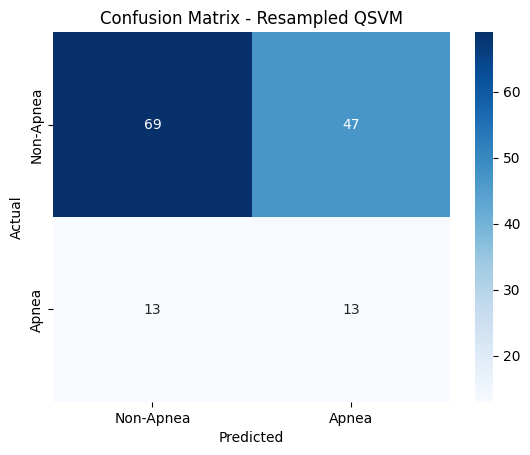

In [15]:
from qiskit.circuit.library import PauliFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC

# Define simulator and kernel
simulator = AerSimulator(method='statevector')
feature_map = PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'])
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=simulator)

# QSVM
qsvc = QSVC(quantum_kernel=quantum_kernel)
qsvc.fit(X_train_resampled, y_train_resampled)
y_pred_qsvm = qsvc.predict(X_test_bal)

# Evaluation
print("🎯 Resampled QSVM Accuracy:", round(accuracy_score(y_test_bal, y_pred_qsvm) * 100, 2), "%")
print("Classification Report (QSVM):\n", classification_report(y_test_bal, y_pred_qsvm))

# Confusion matrix
cm = confusion_matrix(y_test_bal, y_pred_qsvm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Apnea', 'Apnea'], yticklabels=['Non-Apnea', 'Apnea'])
plt.title("Confusion Matrix - Resampled QSVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**QSVM with resample balanced data- ZZ Feature Map**

ERROR:stevedore.extension:Could not load 'ibm_backend': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_backend': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': No module named 'qiskit.primitives.containers'


🎯 Resampled QSVM (ZZ) Accuracy: 51.41 %
Classification Report (QSVM with ZZ):
               precision    recall  f1-score   support

         0.0       0.80      0.54      0.65       116
         1.0       0.16      0.38      0.22        26

    accuracy                           0.51       142
   macro avg       0.48      0.46      0.44       142
weighted avg       0.68      0.51      0.57       142



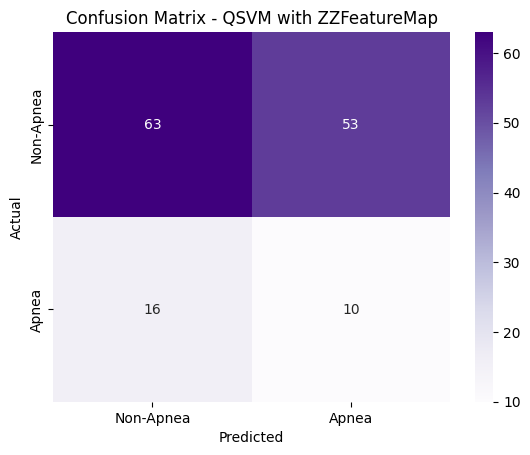

In [16]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC

# Define simulator and kernel using ZZFeatureMap
simulator = AerSimulator(method='statevector')
feature_map_zz = ZZFeatureMap(feature_dimension=2, reps=2, entanglement='linear')
quantum_kernel_zz = QuantumKernel(feature_map=feature_map_zz, quantum_instance=simulator)

# QSVM using ZZFeatureMap
qsvc_zz = QSVC(quantum_kernel=quantum_kernel_zz)
qsvc_zz.fit(X_train_resampled, y_train_resampled)
y_pred_qsvm_zz = qsvc_zz.predict(X_test_bal)

# Evaluation
print("🎯 Resampled QSVM (ZZ) Accuracy:", round(accuracy_score(y_test_bal, y_pred_qsvm_zz) * 100, 2), "%")
print("Classification Report (QSVM with ZZ):\n", classification_report(y_test_bal, y_pred_qsvm_zz))

# Confusion matrix
cm = confusion_matrix(y_test_bal, y_pred_qsvm_zz)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Non-Apnea', 'Apnea'], yticklabels=['Non-Apnea', 'Apnea'])
plt.title("Confusion Matrix - QSVM with ZZFeatureMap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


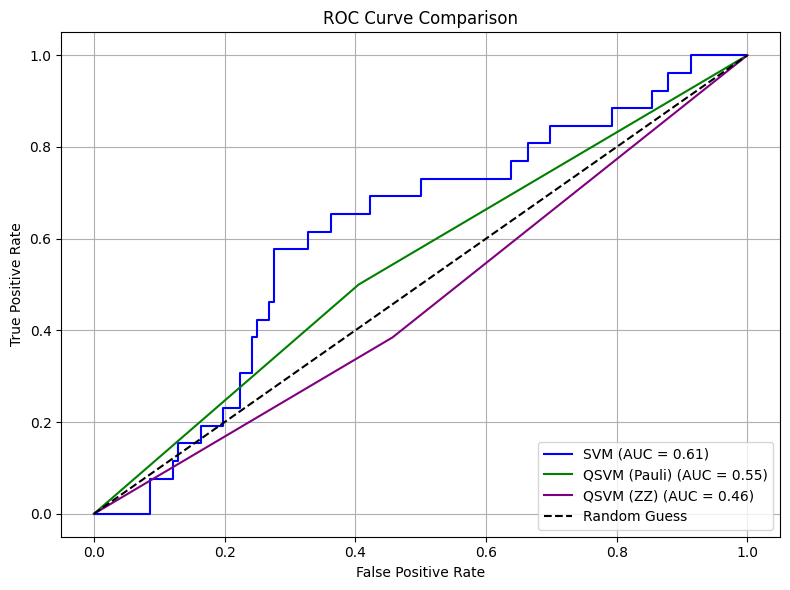

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Classical SVM decision function
svm_scores = svm_model.decision_function(X_test_bal)
fpr_svm, tpr_svm, _ = roc_curve(y_test_bal, svm_scores)
auc_svm = auc(fpr_svm, tpr_svm)

# QSVM scores (use +1 for predicted class 1, -1 for class 0)
qsvm_scores = np.where(y_pred_qsvm == 1, 1, -1)
fpr_qsvm, tpr_qsvm, _ = roc_curve(y_test_bal, qsvm_scores)
auc_qsvm = auc(fpr_qsvm, tpr_qsvm)

qsvm_zz_scores = np.where(y_pred_qsvm_zz == 1, 1, -1)
fpr_qsvm_zz, tpr_qsvm_zz, _ = roc_curve(y_test_bal, qsvm_zz_scores)
auc_qsvm_zz = auc(fpr_qsvm_zz, tpr_qsvm_zz)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})', color='blue')
plt.plot(fpr_qsvm, tpr_qsvm, label=f'QSVM (Pauli) (AUC = {auc_qsvm:.2f})', color='green')
plt.plot(fpr_qsvm_zz, tpr_qsvm_zz, label=f'QSVM (ZZ) (AUC = {auc_qsvm_zz:.2f})', color='purple')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


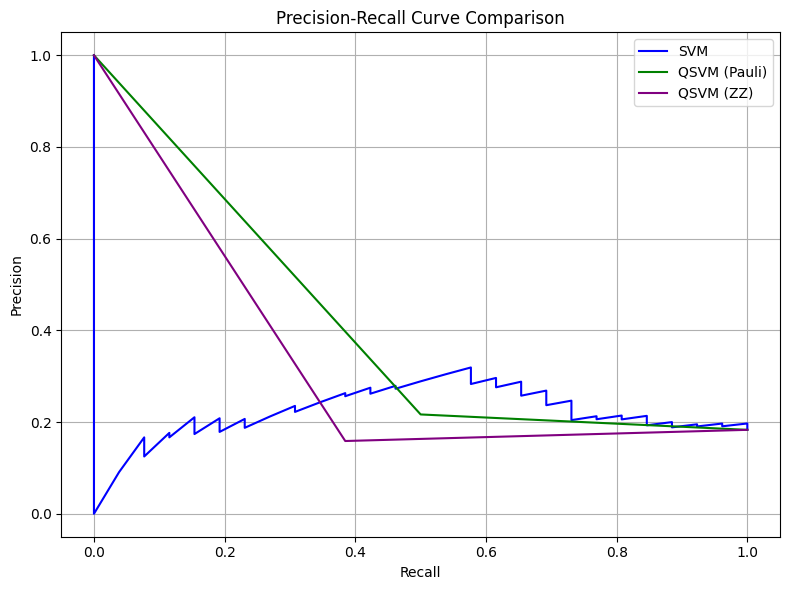

In [18]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall
precision_svm, recall_svm, _ = precision_recall_curve(y_test_bal, svm_scores)
precision_qsvm, recall_qsvm, _ = precision_recall_curve(y_test_bal, qsvm_scores)
precision_qsvm_zz, recall_qsvm_zz, _ = precision_recall_curve(y_test_bal, qsvm_zz_scores)

# Plot PR
plt.figure(figsize=(8, 6))
plt.plot(recall_svm, precision_svm, label='SVM', color='blue')
plt.plot(recall_qsvm, precision_qsvm, label='QSVM (Pauli)', color='green')
plt.plot(recall_qsvm_zz, precision_qsvm_zz, label='QSVM (ZZ)', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()
